#### Instalação das bibliotecas

In [1]:
!pip install nltk

In [2]:
!pip install TextBlob

In [3]:
!pip install tqdm

In [52]:
!pip install seaborn

#### Importação das bibliotecas a serem utilizadas para o processamento

In [86]:
import pandas as pd
import numpy as np
from keras.layers import Dropout
from tensorflow import keras
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import  RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf 
import joblib
from warnings import simplefilter

import re
import matplotlib.pyplot as plt
from textblob import TextBlob

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from tqdm import tqdm

import seaborn as sns


simplefilter("ignore")

np.random.seed(0)

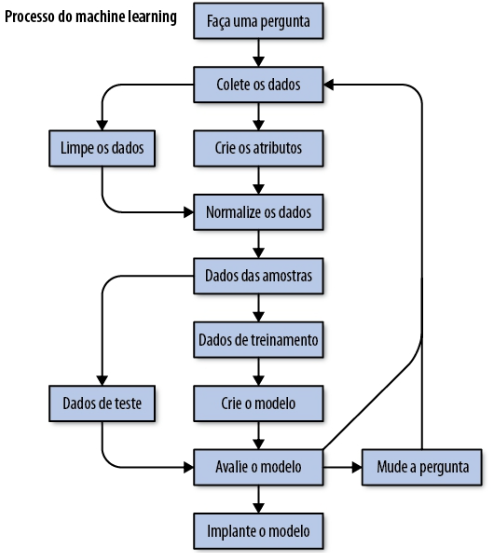

In [2]:
from IPython.display import Image
from IPython.core.display import HTML

PATH = "/Users/Maicon Santos/modelos_teste/"
Image(filename = PATH + "modelML.png", width=500, height=100)

#### Hipotese

A primeira parte é consumir o dataset neste link e gerar conhecimento sobre o perfil de quem está falando do bitcoin.

A segunda parte consiste em realizar uma análise de sentimentos dos tweets do dataset, para saber se as pessoas possuem uma percepção negativa ou positiva sobre a criptomoeda.

Link Base: https://www.kaggle.com/datasets/226bc93769b5b28697eb8fc4a107040b3145c01640c91c16bde8424170f2820e

#### Coleta dos Dados

In [3]:
df = pd.read_csv('Bitcoin_tweets.csv')

#### Pré-Processamento, Limpeza dos Dados

In [4]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2573255 entries, 0 to 2573254
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_name         object 
 1   user_location     object 
 2   user_description  object 
 3   user_created      object 
 4   user_followers    float64
 5   user_friends      object 
 6   user_favourites   object 
 7   user_verified     object 
 8   date              object 
 9   text              object 
 10  hashtags          object 
 11  source            object 
 12  is_retweet        object 
dtypes: float64(1), object(12)
memory usage: 255.2+ MB


#### Foi realizado a verificação dos valores nulos.

In [6]:
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum() / df.isnull().count()*100
percent_2 = (round(percent_1, 2)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total de Nulos', '%'])
missing_data = missing_data.sort_values(by=['Total de Nulos'], ascending=False)
missing_data

,Total de Nulos,%
user_location,1261627,49.03
user_description,318865,12.39
hashtags,17263,0.67
source,3845,0.15
is_retweet,531,0.02
user_followers,225,0.01
user_friends,225,0.01
user_favourites,225,0.01
user_verified,225,0.01
date,225,0.01


#### Foi realizado a exclusão das colunas.

##### 'user_name', 'is_retweet','user_friends','user_favourites', 'hashtags'

In [7]:
columns = ['user_name', 'is_retweet','user_friends','user_favourites', 'hashtags']

df_new = df.drop(columns, axis=1)

In [8]:
df_new.head()

,user_location,user_description,user_created,user_followers,user_verified,date,text,source
0,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,Twitter Web App
1,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...",Twitter for Android
2,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",Twitter Web App
3,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,dlvr.it
4,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,Twitter Web App


#### A conversão da variavel data para datetime

In [9]:
df_new["date"] = pd.to_datetime(df_new["date"],errors='coerce')
df_new["date"] = df_new["date"].apply(lambda x: x.date() )

#### Exclusão dos dados duplicados

In [10]:
df_new = df_new.drop_duplicates()

#### Na localidade foi substituido o valor Nan, por global

In [11]:
df_new['user_location'] = df_new['user_location'].replace(np.nan, 'Global', regex=True)

In [12]:
df_new

,user_location,user_description,user_created,user_followers,user_verified,date,text,source
0,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,False,2021-02-10,Blue Ridge Bank shares halted by NYSE after #b...,Twitter Web App
1,Global,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,False,2021-02-10,"😎 Today, that's this #Thursday, we will do a ""...",Twitter for Android
2,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,False,2021-02-10,"Guys evening, I have read this article about B...",Twitter Web App
3,Global,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,False,2021-02-10,$BTC A big chance in a billion! Price: \487264...,dlvr.it
4,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,False,2021-02-10,This network is secured by 9 508 nodes as of t...,Twitter Web App
...,...,...,...,...,...,...,...,...
2573250,Global,There's a new social order aligning. This is ...,2021-03-06 13:47:42,50.0,False,2022-03-14,This should tell you plenty. DO NOT hold pape...,Twitter for Android
2573251,KİEV,BİTC0İN\n\nCAN U SEND GİFT PLS F0R WAR :(\n\nI...,2022-03-14 19:29:12,0.0,False,2022-03-14,TEwL3iCv1Xyn3Vr7C6CHMqdS36ixA6QWvc\n\ncan you ...,Twitter Web App
2573252,Global,OVER 100K FOLLOWERS ON TELEGRAM https://t.co/R...,2021-08-29 04:38:25,2105.0,False,2022-03-14,#TOP01 LOSSER LIST TODAY 14/03/22 📢\n\n#IMX/US...,Twitter for iPhone
2573253,Global,🤖 #crypto #trading,2017-09-22 10:00:27,420.0,False,2022-03-14,I am the only crazy person here? \n\n#btc #alts,Twitter for iPhone


#### A conversão da variavel user_created para datetime

In [13]:
df_new["user_created"] = pd.to_datetime(df_new["user_created"],errors='coerce')
df_new["user_created"] = df_new["user_created"].apply(lambda x: x.date() )

In [14]:
df_new['user_followers'] = df_new['user_followers'].astype(int, errors='ignore')

In [15]:
df_new.head()

,user_location,user_description,user_created,user_followers,user_verified,date,text,source
0,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26,8534.0,False,2021-02-10,Blue Ridge Bank shares halted by NYSE after #b...,Twitter Web App
1,Global,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17,6769.0,False,2021-02-10,"😎 Today, that's this #Thursday, we will do a ""...",Twitter for Android
2,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10,128.0,False,2021-02-10,"Guys evening, I have read this article about B...",Twitter Web App
3,Global,I will post a lot of buying signals for BTC tr...,2019-09-28,625.0,False,2021-02-10,$BTC A big chance in a billion! Price: \487264...,dlvr.it
4,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03,1249.0,False,2021-02-10,This network is secured by 9 508 nodes as of t...,Twitter Web App


In [16]:
df_new['source'].value_counts()

Twitter for Android          768927
Twitter Web App              667046
Twitter for iPhone           499638
IFTTT                         38458
dlvr.it                       31030
                              ...  
Twitter Search Terms              1
ganuooh                           1
Reacti's tweetdeck                1
erased22226555_ocq7EaOEIF         1
TwitterGeoBotLLJK                 1
Name: source, Length: 1986, dtype: int64

#### Foi selecionado os dados em que foi usado esses valores ('Twitter Web App', 'Twitter for Android', 'Twitter for iPhone')
#### Por ter uma maior representatividade nos dados.

In [17]:
sources = ['Twitter Web App', 'Twitter for Android', 'Twitter for iPhone']
df_new_ = df_new[df_new.source.isin(sources)]

In [18]:
df_new_.source.value_counts()

Twitter for Android    768927
Twitter Web App        667046
Twitter for iPhone     499638
Name: source, dtype: int64

In [19]:
df_new_['user_location'].value_counts()

Global                           977467
United States                     26493
New York, USA                     11887
London, England                   10642
India                              9826
                                  ...  
Hazyview, South Africa                1
Best city in the world... YYC         1
Fishers, IN                           1
Que mas da                            1
enugu state                           1
Name: user_location, Length: 66318, dtype: int64

In [20]:
result_source = df_new_['source'].value_counts()

#### Com todas as localidade no mundo, em que foi adquirido os dados, é possível perceber que a maior menção de twitter em bitcoin, foi em celulares android, em segundo lugar foi no uso na Web APP e por último em celulares IPhones.

<AxesSubplot:>

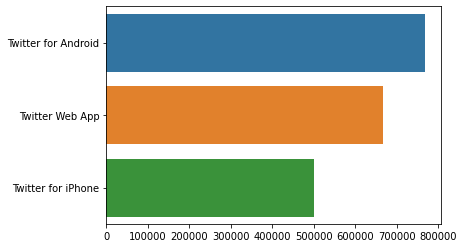

In [21]:
sns.barplot(y=result_source.index, x=result_source.values)

In [22]:
#df_new_[(df_new_['user_location'].value_counts() >= 1000) & (df_new_['user_location'].value_counts() < 977467)]
#(df_new_.value_counts()[(df_new_['user_location'].value_counts() >= 1000) & (df_new2['counts'] < 531170)]).reset_index(drop=True)
result_source_location = df_new_['user_location'].value_counts()[(df_new_['user_location'].value_counts() > 5000) & (df_new_['user_location'].value_counts() < 977467)]

#df_new_['user_location'].value_counts()[(df_new_['user_location'].value_counts() > 1000) & (df_new_['user_location'].value_counts() < 977467)]

#### Retirando a localidade global, em que pode ser em qualquer local do mundo, o país que teve mais menções de bitcoin, foi nos USA e os seus estados, em segundo lugar, podemos perceber nos dados e na figura abaixo, em que o país da India e como também o reino unido, teve uma grande menção significativa em bitcoin.

<AxesSubplot:>

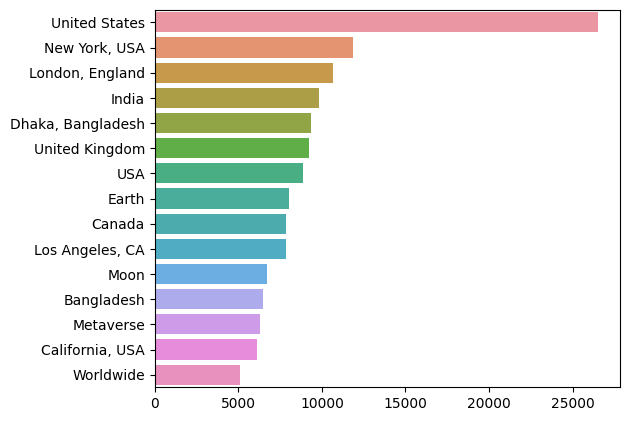

In [23]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

sns.barplot(y=result_source_location.index, x=result_source_location.values)

In [24]:
#df_new_.groupby(['user_location', 'source']).size().to_frame('total').reset_index()
df_new_['counts'] = df_new_['user_location'].map(df_new_['user_location'].value_counts())

In [25]:
df_new3 = (df_new_[(df_new_['counts'] >= 5000) & (df_new_['counts'] < 977467)]).reset_index(drop=True)
df_new3

,user_location,user_description,user_created,user_followers,user_verified,date,text,source,counts
0,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10,128.0,False,2021-02-10,"Guys evening, I have read this article about B...",Twitter Web App,10642
1,Moon,#Bitcoin,2010-07-12,4.0,False,2021-02-10,Buy #Bitcoin with 5% LIFETIME cashback on fees...,Twitter Web App,6737
2,"New York, USA",#Bitcoin #Cryptocurrency,2019-10-05,394.0,False,2021-02-10,My opinion is the clients - either Migros Swit...,Twitter for iPhone,11887
3,United Kingdom,#FinTechUK | Doing our bit to make the UK a gl...,2015-09-07,1950.0,False,2021-02-10,"2,292.2542 of #BTC was transferred today from ...",Twitter for Android,9208
4,"California, USA",It's me Esteeb. Crypto Fan. $BTC and $CEL lead...,2011-11-15,842.0,False,2021-02-10,🤝 Follow me on @betfury_io. Let's hunt for Bit...,Twitter Web App,6132
...,...,...,...,...,...,...,...,...,...
140663,Metaverse,#Blockchain | #Crypto | #Invest | #Trading | #...,2021-06-21,147.0,False,2022-03-14,#MEXC Staking allows you to stake and earn yie...,Twitter Web App,6299
140664,United Kingdom,NaN,2019-06-13,4999.0,False,2022-03-14,"@paddi_hansen Great news, thanks for the updat...",Twitter for Android,9208
140665,"London, England","Crypto, NFTs, Financial Services Tech Head Hun...",2021-09-21,2656.0,False,2022-03-14,"ECON a committee of the European Parliament, h...",Twitter for iPhone,10642
140666,United Kingdom,$Nano $XNO P2P digital gold currency and hardm...,2012-01-09,5424.0,False,2022-03-14,@KanyeRespecter @DigiEconomist @ncweaver What ...,Twitter for Android,9208


In [26]:
df_new3['user_location'].value_counts()

United States        26493
New York, USA        11887
London, England      10642
India                 9826
Dhaka, Bangladesh     9355
United Kingdom        9208
USA                   8843
Earth                 8020
Canada                7842
Los Angeles, CA       7824
Moon                  6737
Bangladesh            6458
Metaverse             6299
California, USA       6132
Worldwide             5102
Name: user_location, dtype: int64

In [27]:
result__location_source = df_new3.groupby(['user_location', 'source']).size().to_frame('total').reset_index()

#### Nessa Imagem, podemos visualizar, os paises em que falaram sobre bitcoin (Android, Web App ou IPhone). Dessa forma, os USA teve uma maior menção de bitcoin no Twitter com o uso do Twitter em Android, Web App e Iphone. Pode-se destacar que o país Bangladesh teve um grande menção pelo o uso de celulares Android.

<AxesSubplot:xlabel='total', ylabel='user_location'>

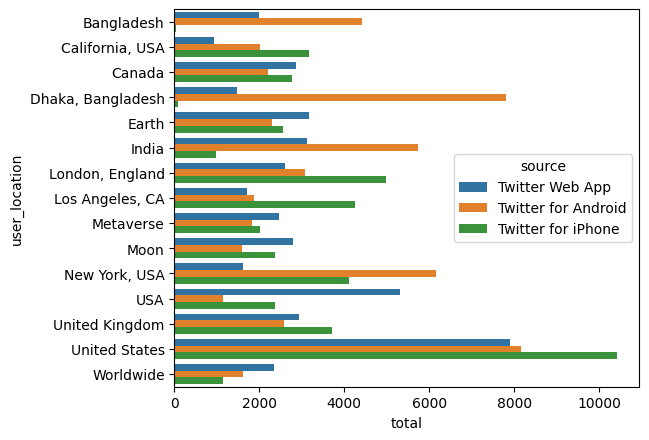

In [28]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

sns.barplot(x='total', y='user_location', hue='source', data=result__location_source)

In [29]:
result_source_date = df_new3.groupby(['source', 'user_created']).size().to_frame('total_source_date').reset_index()

In [30]:
result_source_date.total_source_date.max()

2378

In [33]:
result_source_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10366 entries, 0 to 10365
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   source             10366 non-null  object        
 1   user_created       10366 non-null  datetime64[ns]
 2   total_source_date  10366 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 243.1+ KB


In [34]:
result_source_date['user_created'] = pd.to_datetime(result_source_date['user_created'], errors='ignore')

In [128]:
#result_source_date[result_source_date['user_created'].dt.year == '2021']
#result_source_date[result_source_date['user_created'].dt.year == '2021']
#result_source_date['user_created'].loc['2016' : '2022']
import datetime

#result_source_date[result_source_date['user_created'] > datetime.datetime(2017,1,1)]
result_source_date[(result_source_date.source == 'Twitter Web App') & (result_source_date.user_created > datetime.datetime(2020,1,1))].user_created

2715   2020-01-03
2716   2020-01-04
2717   2020-01-05
2718   2020-01-06
2719   2020-01-07
          ...    
3485   2022-03-13
3486   2022-03-14
3487   2022-03-15
3488   2022-03-17
3489   2022-03-18
Name: user_created, Length: 775, dtype: datetime64[ns]

#### Durante o periodo do tempo. No ano de 2021 e no início de 2022 teve um grande aumento de menção de bitcoin no Twitter. Pode-se destacar, em que no ano de 2022, no início, Twitter com Android teve um grande número de menções.

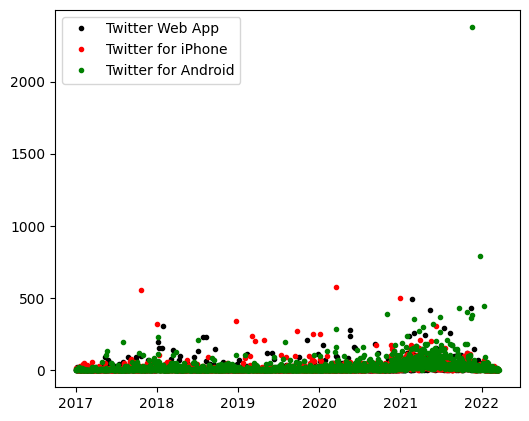

In [133]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

plt.plot(result_source_date[(result_source_date.source == 'Twitter Web App') & (result_source_date.user_created > datetime.datetime(2017,1,1))].user_created, result_source_date[(result_source_date.source == 'Twitter Web App') & (result_source_date.user_created > datetime.datetime(2017,1,1))].total_source_date, '.k', label='Twitter Web App')
plt.plot(result_source_date[(result_source_date.source == 'Twitter for iPhone') & (result_source_date.user_created > datetime.datetime(2017,1,1))].user_created, result_source_date[(result_source_date.source == 'Twitter for iPhone') & (result_source_date.user_created > datetime.datetime(2017,1,1))].total_source_date, '.r', label='Twitter for iPhone')
plt.plot(result_source_date[(result_source_date.source == 'Twitter for Android') & (result_source_date.user_created > datetime.datetime(2017,1,1))].user_created, result_source_date[(result_source_date.source == 'Twitter for Android') & (result_source_date.user_created > datetime.datetime(2017,1,1))].total_source_date, '.g', label='Twitter for Android')
#plt.plot(result_source_date[result_source_date.source == 'Twitter for iPhone'].user_created, result_source_date[result_source_date.source == 'Twitter for iPhone'].total_source_date, '.r', label='Twitter for Iphone')
#plt.plot(result_source_date[result_source_date.source == 'Twitter for Android'].user_created, result_source_date[result_source_date.source == 'Twitter for Android'].total_source_date, '.b', label='Twitter for Android')
plt.legend(loc='best')
plt.show()

## 2 Parte

### Classificação Positivo e Negativo

In [38]:
from tqdm import tqdm

df2_ = df

df2_.dropna(subset=['hashtags'], inplace=True)

df2_ = df2_[['text']] 
df2_.columns = ['tweets']
df2_.head()

,tweets
0,Blue Ridge Bank shares halted by NYSE after #b...
1,"😎 Today, that's this #Thursday, we will do a ""..."
3,$BTC A big chance in a billion! Price: \487264...
4,This network is secured by 9 508 nodes as of t...
5,💹 Trade #Crypto on #Binance \n\n📌 Enjoy #Cashb...


In [174]:
!pip install -U nltk

#### Download das bibliotecas de texto, para realizar a etapa de pre-processamento

In [40]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
#nltk.download()
nltk.download('popular', halt_on_error=False)
stop_words = nltk.corpus.stopwords.words(['english'])


print(stop_words)

[nltk_data] Downloading package wordnet to C:\Users\Maicon
[nltk_data]     Santos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Maicon
[nltk_data]     Santos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Maicon
[nltk_data]     Santos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to C:\Users\Maicon
[nltk_data]    |     Santos\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to C:\Users\Maicon
[nltk_data]    |     Santos\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\gazetteers.zip.
[nltk_data]    | Downloading package genesis to C:\Users\Maicon
[nltk_data]    |     Sant

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Maicon
[nltk_data]    |     Santos\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | 
[nltk_data]  Done downloading collection popular


In [41]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

def cleaning(data):
  #remove urls
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)

#### Foi realizado uma limpeza nos textos, removendo todo tipo de emojis, palavras com caracteres especiais.

In [42]:
#import nltk
#nltk.download()

df2_['cleaned_tweets'] = df2_['tweets'].apply(cleaning)
df2_.head()

,tweets,cleaned_tweets
0,Blue Ridge Bank shares halted by NYSE after #b...,Blue Ridge Bank share halted NYSE ATM announce...
1,"😎 Today, that's this #Thursday, we will do a ""...",Today Take friend expe
3,$BTC A big chance in a billion! Price: \487264...,BTC A big chance billion Price
4,This network is secured by 9 508 nodes as of t...,This network secured node today Soon biggest b...
5,💹 Trade #Crypto on #Binance \n\n📌 Enjoy #Cashb...,Trade Enjoy Trading fee Sign link


In [43]:
def getSub(tweet):
    return TextBlob(tweet).sentiment.subjectivity

def getPol(tweet):
    return TextBlob(tweet).sentiment.polarity

#### Foi aplicado um algoritmo para identificar a polaridade dos textos

In [44]:
df2_['sub'] = df2_['cleaned_tweets'].apply(getSub)
df2_['pol'] = df2_['cleaned_tweets'].apply(getPol)
df2_.head()

,tweets,cleaned_tweets,sub,pol
0,Blue Ridge Bank shares halted by NYSE after #b...,Blue Ridge Bank share halted NYSE ATM announce...,0.1,0.00
1,"😎 Today, that's this #Thursday, we will do a ""...",Today Take friend expe,0.0,0.00
3,$BTC A big chance in a billion! Price: \487264...,BTC A big chance billion Price,0.1,0.00
4,This network is secured by 9 508 nodes as of t...,This network secured node today Soon biggest b...,0.2,-0.25
5,💹 Trade #Crypto on #Binance \n\n📌 Enjoy #Cashb...,Trade Enjoy Trading fee Sign link,0.5,0.40


#### Foi realizado uma verificacação e adicionado uma label, para identificar se é positivo ou negativo, de acordo com o método anterior, se for menor que zero, aquele twitter é negativo, se não é um twitter positivo.

In [45]:
def getSent(score):
    if score < 0:
        return 'negativo'
    else:
        return 'positivo'

In [46]:
df2_['sentimento'] = df2_['pol'].apply(getSent)
df2_.head()

,tweets,cleaned_tweets,sub,pol,sentimento
0,Blue Ridge Bank shares halted by NYSE after #b...,Blue Ridge Bank share halted NYSE ATM announce...,0.1,0.00,positivo
1,"😎 Today, that's this #Thursday, we will do a ""...",Today Take friend expe,0.0,0.00,positivo
3,$BTC A big chance in a billion! Price: \487264...,BTC A big chance billion Price,0.1,0.00,positivo
4,This network is secured by 9 508 nodes as of t...,This network secured node today Soon biggest b...,0.2,-0.25,negativo
5,💹 Trade #Crypto on #Binance \n\n📌 Enjoy #Cashb...,Trade Enjoy Trading fee Sign link,0.5,0.40,positivo


In [47]:
# Encode Categorical Variable
X = df2_['cleaned_tweets']
y = pd.get_dummies(df2_['sentimento']).values
num_classes = df2_['sentimento'].nunique()

In [50]:
X

0          Blue Ridge Bank share halted NYSE ATM announce...
1                                     Today Take friend expe
3                             BTC A big chance billion Price
4          This network secured node today Soon biggest b...
5                          Trade Enjoy Trading fee Sign link
                                 ...                        
2573250    This tell plenty DO NOT hold paper Take physic...
2573251        TEwL iCv Xyn Vr C CHMqdS ixA QWvc help dollar
2573252    LOSSER LIST TODAY USDT PROFIT To get type sign...
2573253                                       I crazy person
2573254    This coin solid bone new height let go new pea...
Name: cleaned_tweets, Length: 2555992, dtype: object

In [49]:
y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

#### Foi realizado a separação dos dados, em treino e teste com o método train_test_split, separando 20% dos dados para teste.

In [51]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2044793,) (511199,) (2044793, 2) (511199, 2)


#### Foi realizado a etapa de pre-processamento, do texto para numeros.

In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [56]:
from keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(2044793, 30) (511199, 30)


In [57]:
X_train

array([[    0,     0,     0, ...,     4,     3,    29],
       [    0,     0,     0, ..., 12981,   295,   789],
       [    0,     0,     0, ...,  5564,   155,   526],
       ...,
       [    0,     0,     0, ...,    71,    31,    60],
       [    0,     0,     0, ...,     0,  1360,   207],
       [    0,     0,     0, ...,     0,     7,    90]])

In [106]:
#history = model.fit(X_train, np.argmax(y_train,axis=1).reshape(-1, 1), epochs=50, verbose=1)
#y_train
X_train.shape, np.argmax(y_train,axis=1).reshape(-1, 1).shape

((2044793, 30), (2044793, 1))

In [107]:
from tensorflow.keras.layers import LeakyReLU
from keras.regularizers import l2

        #layers.Dense(100, activation="relu", input_shape=[X_train.shape[1]]),
        #layers.Dense(100, activation='relu', input_shape=[X_train.shape[1]]),
        #layers.Dense(100, activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),

np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)
def build_model(X_train, dropout=0.0):
    #if dropout == 0.0:
    model = keras.Sequential([
        layers.Dropout(dropout, input_shape=[X_train.shape[1]]),
        #layers.Dense(400, activation="relu"),
        #layers.Dense(300, activation="relu"),
        #layers.Dense(200, activation="relu"),
        layers.Dense(100, activation="softmax", input_shape=[X_train.shape[1]]),
        layers.Dense(80, activation='softmax'),
        layers.Dense(60, activation='softmax'),
        layers.Dense(40, activation='softmax'),
        layers.Dense(20, activation='softmax'),
        layers.Dense(6, activation='softmax'),
        layers.Dense(1)
      ])
    
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    #optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.90, epsilon=1e-07)
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(
        loss='mse',
        #loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])
    
    return model 


rna_01 = build_model(X_train, 0)
rna_01.fit(X_train, y_train, epochs=5, verbose=1)

%time

Epoch 1/5
63900/63900 [==============================] - 67s 1ms/step - loss: 0.2510 - accuracy: 0.5000
Epoch 2/5
63900/63900 [==============================] - 68s 1ms/step - loss: 0.2500 - accuracy: 0.5000 0s -
Epoch 3/5
63900/63900 [==============================] - 68s 1ms/step - loss: 0.2500 - accuracy: 0.5000
Epoch 4/5
63900/63900 [==============================] - 68s 1ms/step - loss: 0.2500 - accuracy: 0.5000
Epoch 5/5
63900/63900 [==============================] - 67s 1ms/step - loss: 0.2500 - accuracy: 0.5000
Wall time: 0 ns


#### Foi aplicado um algoritmo de rede neural, em que nesse algoritmo, foi aplicado 5 epócas, para obter uma acurária de 10.7%, dessa forma, com essa configuração, o algoritmo não apresentou um bom desempenho.

In [108]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report


y_pred =  np.argmax(rna_01.predict(X_test), axis=1)
print('Acc:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred)*100))
#print(classification_report(np.argmax(y_test,axis=1), y_pred))

Acc:	10.7%


#### Desse modo, o algoritmo só encontrou twitter, negativo, não tendo uma boa generalização com essa configuração

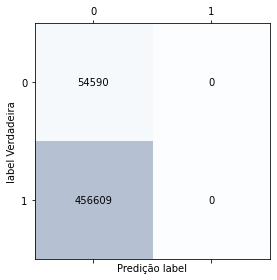

In [125]:
#confusion matrix
confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        plt.xlabel('Predição label')
        plt.ylabel('label Verdadeira')
        plt.tight_layout()

In [109]:
np.argmax(y_train,axis=1).reshape(-1, 1)

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int64)

In [110]:
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=6, n_estimators=1000)
model.fit(X_train, np.argmax(y_train,axis=1).reshape(-1, 1))

[14:28:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Foi aplicado também o algoritmo de XGBoost, para obter a classificação de twitter positivo e negativo, dessa forma, esse algoritmo obteve uma boa classificação de 94.5%. Assim, o algoritmo teve uma boa generalização, sabendo dos twitter positivo e negativo. Conforme apresentado na figura da matriz de confusão.

In [122]:
y_pred_xboost =  model.predict(X_test)
print('Acc:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1), y_pred_xboost)*100))

Acc:	94.5%


In [119]:
#np.argmax(model.predict(X_test), axis=0)
model.predict(X_test).shape

(511199,)

In [121]:
np.argmax(y_test, axis=1)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

#### Com a matriz de confusão, teve uma boa resposta com o algoritmo XGBoost, e podemos perceber que o twitter, foi mencionado o bitcoin de forma positiva, com 20% dos dados para teste.

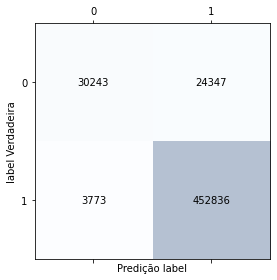

In [126]:
#confusion matrix
confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_xboost)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        plt.xlabel('Predição label')
        plt.ylabel('label Verdadeira')
        plt.tight_layout()